In [1]:
import yfinance as yf
import getFamaFrenchFactors as gff
import pandas as pd
import statsmodels.api as sm
import numpy as np
#ridge, lasso package
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

In [2]:
#import Tesla stock data 
tsla = yf.Ticker("TSLA")
tsla = tsla.history(period="max")
tsla = tsla[['Close']]

tsla_returns = tsla.resample('M').last().pct_change().dropna()
#rename column Close to Ret
tsla_returns.columns = ['Ret']
tsla_returns

,Ret
Date,
2010-07-31 00:00:00-04:00,-0.163240
2010-08-31 00:00:00-04:00,-0.023069
2010-09-30 00:00:00-04:00,0.047741
2010-10-31 00:00:00-04:00,0.070063
2010-11-30 00:00:00-05:00,0.617674
...,...
2023-09-30 00:00:00-04:00,-0.030456
2023-10-31 00:00:00-04:00,-0.197346
2023-11-30 00:00:00-05:00,0.195379


In [3]:
tsla_returns.index = tsla_returns.index.strftime('%Y-%m-%d')
tsla_returns.index = pd.to_datetime(tsla_returns.index)
tsla_returns.name = 'Monthly_return'
tsla_returns

,Ret
Date,
2010-07-31,-0.163240
2010-08-31,-0.023069
2010-09-30,0.047741
2010-10-31,0.070063
2010-11-30,0.617674
...,...
2023-09-30,-0.030456
2023-10-31,-0.197346
2023-11-30,0.195379


In [4]:
ff3_monthly = gff.famaFrench3Factor(frequency = 'm')

#rename columns 'date_ff_factors' : 'Date'
ff3_monthly.rename(columns={'date_ff_factors' : 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)
ff3_monthly.index = pd.to_datetime(ff3_monthly.index)
ff3_monthly

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1926-08-31,0.0264,-0.0117,0.0382,0.0025
1926-09-30,0.0036,-0.0140,0.0013,0.0023
1926-10-31,-0.0324,-0.0009,0.0070,0.0032
1926-11-30,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...
2023-07-31,0.0321,0.0208,0.0411,0.0045
2023-08-31,-0.0239,-0.0316,-0.0106,0.0045
2023-09-30,-0.0524,-0.0251,0.0152,0.0043


In [5]:
#merge tesla returns and fama french factors
tsla_ff3 = pd.merge(tsla_returns, ff3_monthly, left_index=True, right_index=True)
tsla_ff3

,Ret,Mkt-RF,SMB,HML,RF
Date,,,,,
2010-07-31,-0.163240,0.0693,0.0020,-0.0031,0.0001
2010-08-31,-0.023069,-0.0477,-0.0300,-0.0190,0.0001
2010-09-30,0.047741,0.0954,0.0396,-0.0316,0.0001
2010-10-31,0.070063,0.0388,0.0114,-0.0243,0.0001
2010-11-30,0.617674,0.0060,0.0377,-0.0096,0.0001
...,...,...,...,...,...
2023-07-31,0.021622,0.0321,0.0208,0.0411,0.0045
2023-08-31,-0.034962,-0.0239,-0.0316,-0.0106,0.0045
2023-09-30,-0.030456,-0.0524,-0.0251,0.0152,0.0043


In [6]:
#Independent Var: mkt-rf , smb, hml
#dependent var : Ret - rf
#drop NaN of tsla_ff3
tsla_ff3.dropna(inplace=True)

X = tsla_ff3[['Mkt-RF', 'SMB', 'HML']]
y = tsla_ff3['Ret'] - tsla_ff3['RF']

#ridge regression
ridge = Ridge(alpha=0.1) 
ridge.fit(X, y)
print(ridge.coef_, ridge.intercept_)

#Lasso where alpha =0.001
lasso = Lasso(alpha=0.001)
lasso.fit(X, y)
print(lasso.coef_, lasso.intercept_)

[ 1.18555862  0.59910656 -0.71378426] 0.03221918623832977
[ 1.14532495  0.         -0.18255111] 0.03299833300720753


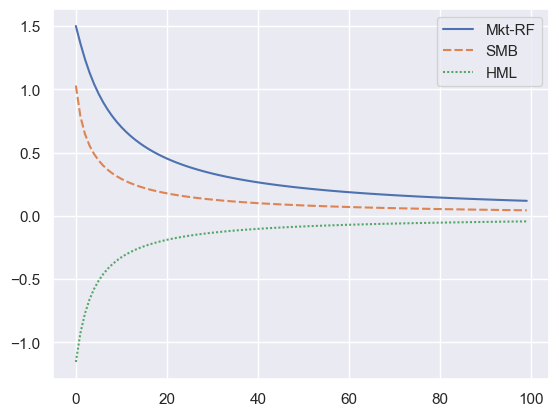

In [9]:
ridge_coeff_list = []

alpha_arr = np.linspace(0, 4, 100)
for alpha in alpha_arr:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    ridge_coeff_list.append(ridge.coef_)
    
ridge_df = pd.DataFrame(ridge_coeff_list, columns=X.columns)
# visualize the coefficients
sns.lineplot(data=ridge_df)
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("whitegrid")
sns.set_context("paper")


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.164e+00, tolerance: 5.501e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

<Axes: >

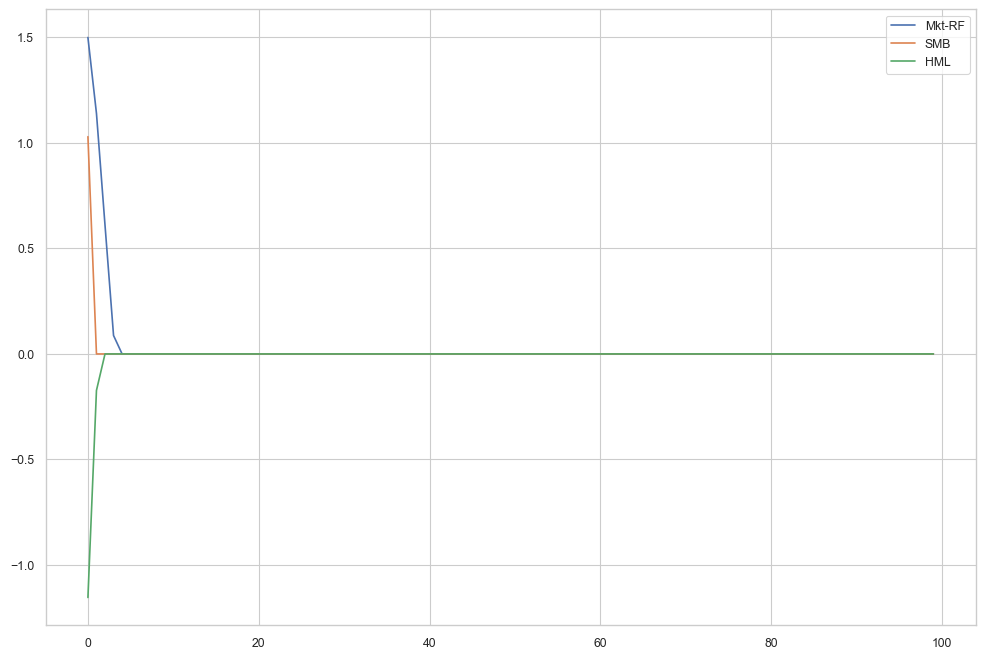

In [13]:
#lasso
lasso_coeff_list = []
alpha_arr = np.linspace(0, 0.1, 100)

for alpha in alpha_arr:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    lasso_coeff_list.append(lasso.coef_)

#save to dataframe
lasso_df = pd.DataFrame(lasso_coeff_list, columns=X.columns)
# visualize the coefficients
lasso_df.plot()

#팩터 많이 사용할 때 라쏘규제로 변수선택